In [1]:
from UnetDetect import getUnet, shape_detect
from UnetDetect import DoubleConv, Down, Up, OutConv, UNet
from yoloDetect import seg_by_label
import numpy as np

In [2]:
seg_imgs, centers, positions = seg_by_label(r'content\DATA_unlabel\06253001\06253001_FILE2.bmp', r'content\pred_result\06253001\labels\06253001_FILE2.txt')

# seg_imgs, centers = seg_by_label(r'content\DATA_unlabel\16060746\16060746_FILE0.bmp', r'content\pred_result\16060746\labels\16060746_FILE0.txt')

# 'testmasked\\test' + str(idx) + '.txt'

pred = []
pred1 = []
pred2 = []

# md = getUnet(md_path = r'C:\Users\user\OneDrive\桌面\vertex\weights\Unet\unet0328H.opt')
# for idx, seg_img in enumerate(seg_imgs):
#     pred.append(shape_detect(seg_img, md, Histeq=False, Snake=False, save_path=None, img_size=224, t=0.7))

md = getUnet(md_path = r'C:\Users\user\OneDrive\桌面\vertex\weights\Unet\unet0424H.opt')
for idx, seg_img in enumerate(seg_imgs):
    pred1.append(shape_detect(seg_img, md, Snake=False, save_path=None, img_size=224, t=0.7))

md = getUnet(md_path = r'C:\Users\user\OneDrive\桌面\vertex\weights\Unet\unet0425H.opt')
for idx, seg_img in enumerate(seg_imgs):
    pred2.append(shape_detect(seg_img, md, Snake=False, save_path=None, img_size=256, t=0.7))

pred = [(p1 + p2)/2 for p1, p2 in zip(pred1, pred2)]

for i in range(len(pred1)):
    np.savetxt('testmasked\\test' + str(i) + '.txt', pred[i], fmt='%d')

In [3]:
# import torch

# md = torch.load(r'C:\Users\user\OneDrive\桌面\vertex\weights\Unet\unet0424H.opt', map_location='cpu')

In [4]:
# from matplotlib import pyplot as plt

# plt.figure()
# plt.title('Loss')
# plt.plot(md['train_loss'])

# plt.figure()
# plt.title('Accuracy')
# plt.plot(md['train_acc'])
# plt.plot(md['test_acc'])
# plt.legend(['train','test'])

In [5]:
import numpy as np
import math
from PIL import Image
import torchvision.transforms.functional as TF
from matplotlib import pyplot as plt

fs = os.listdir('testmasked')
degrees = [] # save rotation degree
fs.sort(key=lambda x: int(x[4:].split('.')[0]))

for idx, (f, seg_img) in enumerate(zip(fs, seg_imgs)):
    msk = np.loadtxt(os.path.join('testmasked', f))
    plt.figure()
    plt.imshow(seg_img, cmap='gray')
    plt.imshow(np.ma.masked_where(msk==0, msk), cmap='jet', alpha=0.5)

    a1, a2 = None, None
    x1, y1 = centers[idx]
    X = np.linspace(-500,500)
    if idx != 0:
        x0, y0 = centers[idx-1]       
        
        a1 = (y1-y0)/(x1-x0)
        b1 = seg_img.size[1]/2 - a1 * seg_img.size[0]/2

        # plt.plot(X, a1*X+b1)
   
    if idx < len(centers)-1:
        x2, y2 = centers[idx+1]

        a2 = (y2-y1)/(x2-x1)
        b2 = seg_img.size[1]/2 - a2 * seg_img.size[0]/2

        # plt.plot(X, a2*X+b2)

    if a1 != None and a2 != None:
        a = (a1 + a2)/2
        b = seg_img.size[1]/2 - a * seg_img.size[0]/2

        # plt.plot(X, a*X+b)
        d = 90-math.degrees(math.atan(a))
    elif a1 != None:
        d = 90-math.degrees(math.atan(a1))
    elif a2 != None:
        d = 90-math.degrees(math.atan(a2))

    degrees.append(d)
    plt.imshow(TF.rotate(seg_img, -d, expand=True), cmap='gray')
    msk = np.array(TF.rotate(Image.fromarray(msk), -d, expand=True))
    plt.imshow(np.ma.masked_where(msk==0, msk), cmap='jet', alpha=0.5)

    plt.xlim([0,seg_img.size[0]])
    plt.ylim([seg_img.size[1],0])
    # plt.plot(x0, y0, 'r+')

ValueError: too many values to unpack (expected 2)

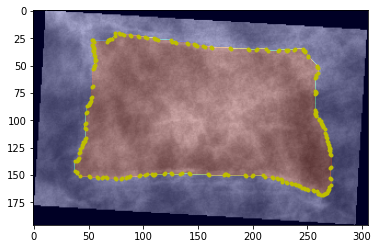

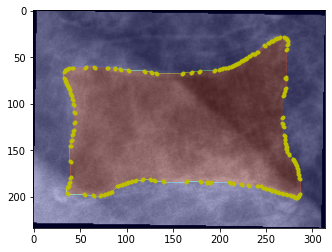

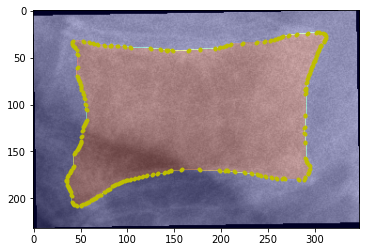

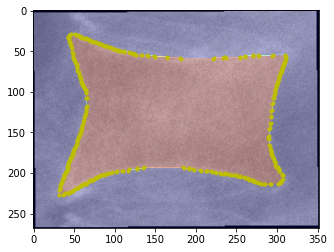

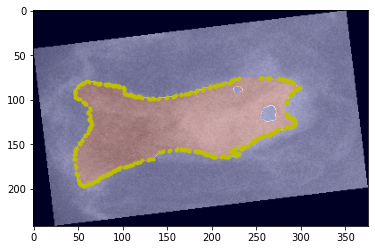

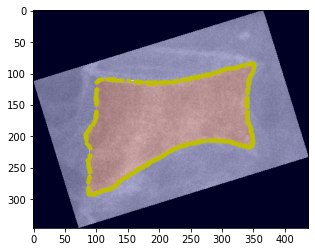

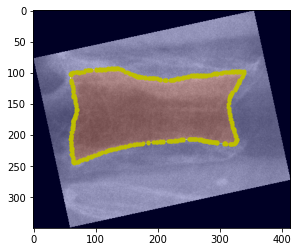

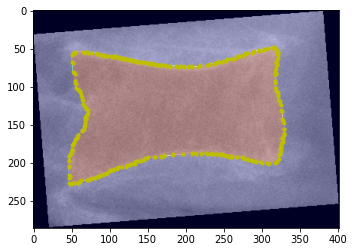

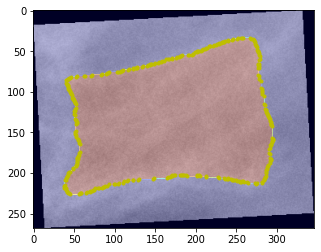

In [6]:
import numpy as np
import cv2

from matplotlib import pyplot as plt

fdir = 'testmasked'
for fname, d, seg_img in zip(fs, degrees, seg_imgs):
    binary = np.loadtxt(os.path.join(fdir, fname), dtype=np.uint8)
    
    # ratation
    binary = np.array(TF.rotate(Image.fromarray(binary), -d, expand=True))
    seg_img = TF.rotate(seg_img, -d, expand=True)
    
    # plt.imshow(cv2.Canny(binary, 100, 200), alpha=0.3)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # several cluster of contours may be found
    if len(contours) > 1:
        contours.sort(key=lambda x: x.shape[0], reverse=True)
        contours = contours[0]

    conts = np.squeeze(np.array(contours))
    
    fig = plt.figure()
    plt.imshow(seg_img, cmap='gray')
    plt.imshow(binary, alpha=0.3, cmap='jet')
    for cont in conts:
        plt.plot(cont[0], cont[1], 'y.')


3.402769771061756
0.9444683228196027
179.056944767529
179.5197211843606
173.0252433514142
162.8104452842636
167.7969530712375
175.36809775026433
176.845157135208


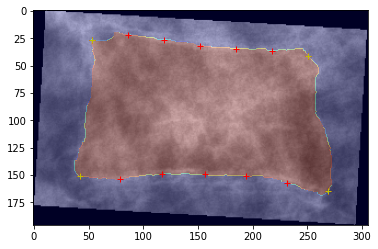

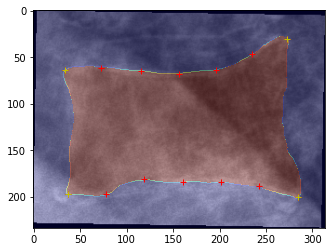

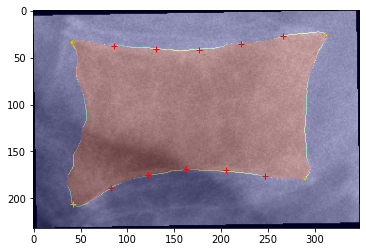

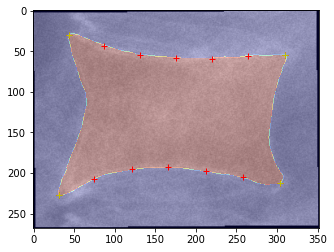

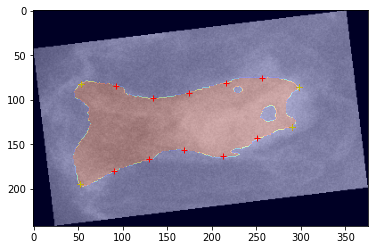

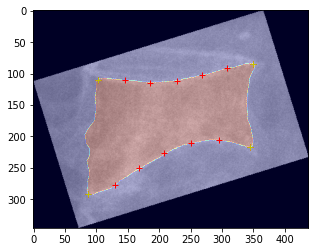

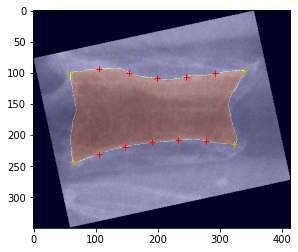

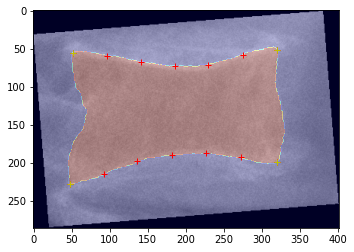

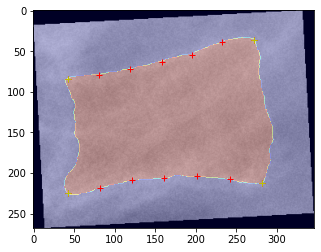

In [7]:
from segfunct import minCornerDistance, edge_segment, get_corner
import pandas as pd

feature = []

fdir = 'testmasked'
for fname, d, seg_img in zip(fs, degrees, seg_imgs):

    print(d)

    binary = np.loadtxt(os.path.join(fdir, fname), dtype=np.uint8)
    
    # ratation
    seg_img = TF.rotate(seg_img, -d, expand=True)

    cs = minCornerDistance(binary, angle=-d)
    # cs = get_corner(binary)
    # cs[1], cs[2] = cs[2], cs[1]

    plt.figure()
    plt.imshow(seg_img, cmap='gray')
    plt.imshow(np.array(TF.rotate(Image.fromarray(binary), -d, expand=True)), alpha=0.3, cmap='jet')
    
    us = edge_segment(cs[0], cs[1], binary, angle=-d, n=6)
    ds = edge_segment(cs[2], cs[3], binary, angle=-d, upper=False, n=6)

    for u, d in zip(us, ds):
        plt.plot(*u, 'r+')
        plt.plot(*d, 'r+')
    for c in cs:
        plt.plot(*c, 'y+')

    feature.append(np.sqrt(np.sum(np.square(np.array(us) - np.array(ds)), axis=1)))

df2 = pd.DataFrame(feature, columns=['Len{}'.format(i) for i in range(7)])

In [8]:
df2['Len_ratio0'] = df2['Len1']/df2['Len0']
df2['Len_ratio1'] = df2['Len3']/df2['Len0']
df2['Len_ratio2'] = df2['Len5']/df2['Len0']
# df2['Len_ratio3'] = df2['Len7']/df2['Len0']
df2['pos_encode'] = np.array([1 if 'T' in p else 0 for p in positions])
df2.head()

Len0        Len1        Len2        Len3        Len4        Len5  \
0  124.486947  132.185476  122.016392  117.068356  116.348614  120.702113   
1  133.033830  136.091881  116.068945  116.107709  120.149906  142.225174   
2  173.002890  152.052622  134.301899  127.663621  135.944842  150.206524   
3  197.428468  164.438438  141.354165  135.369864  138.231690  149.120756   
4  113.004425   96.046864   69.180922   64.280635   82.054860   67.268120   

         Len6  Len_ratio0  Len_ratio1  Len_ratio2  pos_encode  
0  125.299641    1.061842    0.940407    0.969597           1  
1  170.423003    1.022987    0.872768    1.069090           1  
2  154.434452    0.878902    0.737928    0.868231           1  
3  157.114608    0.832901    0.685665    0.755315           1  
4   44.721360    0.849939    0.568833    0.595270           0

In [10]:
import pickle

with open('./MLmodel.pickle', 'rb') as f:
    mds = pickle.load(f)

preds = []
for i in range(len(mds)):
    preds.append(mds[i]['dec'].predict(df2.drop(['Len1','Len2','Len4','Len5'], axis=1)))

preds = np.where(np.sum(np.array(preds).T, axis=1) > 3, 1, 0)

idxs = []
for idx, pred in enumerate(preds):
    if pred == 0:
        idxs.append(idx)

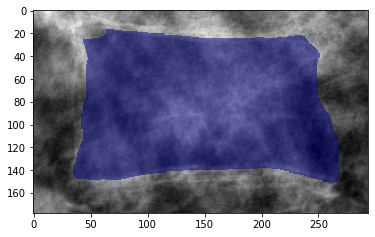

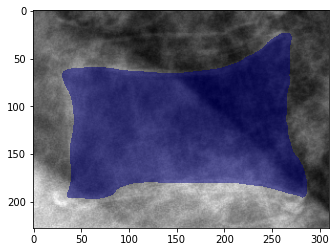

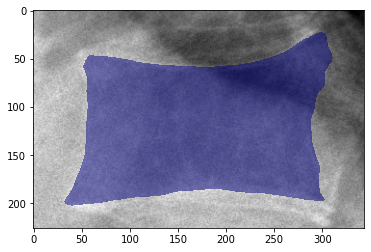

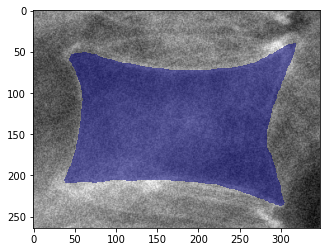

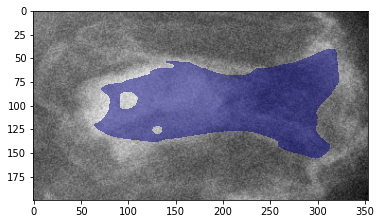

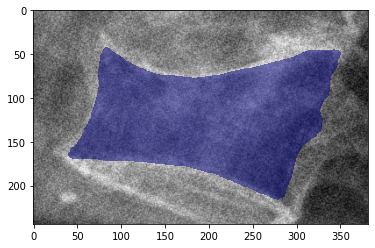

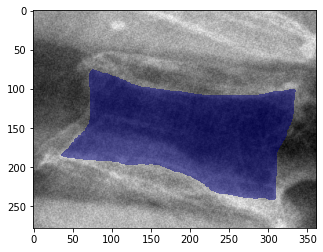

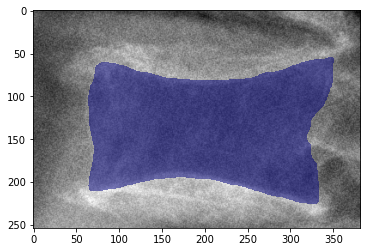

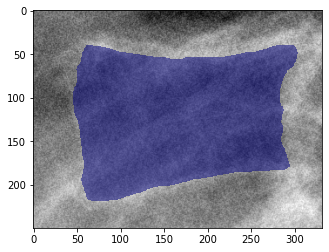

In [10]:
for f, i in zip(fs, range(len(seg_imgs))):
    color = 'gray' if not i in idxs else 'Blues'
    plt.figure()
    plt.imshow(seg_imgs[i], cmap=color)
    a = np.loadtxt(os.path.join('testmasked', f))
    plt.imshow(np.ma.masked_where(a==0, a), cmap='jet', alpha=0.5)

In [12]:
df2.describe()

Len0        Len1        Len2        Len3        Len4        Len5  \
count    9.000000    9.000000    9.000000    9.000000    9.000000    9.000000   
mean   153.415933  142.171792  122.708911  115.634293  118.913022  128.512265   
std     28.796623   21.646692   21.947975   22.575963   20.552488   29.768650   
min    113.004425   96.046864   69.180922   64.280635   82.054860   67.268120   
25%    133.033830  136.003676  118.152444  116.107709  108.503456  114.738834   
50%    144.031247  139.003597  130.096118  117.068356  116.348614  135.014814   
75%    173.046237  156.051274  136.194714  127.663621  135.944842  149.120756   
max    197.428468  167.672299  141.354165  143.031465  150.119952  168.297356   

             Len6  Len_ratio0  Len_ratio1  Len_ratio2  pos_encode  
count    9.000000    9.000000    9.000000    9.000000    9.000000  
mean   136.398875    0.933468    0.761860    0.846643    0.444444  
std     39.495446    0.077891    0.147935    0.198652    0.527046  
min     44.721360    0.832901    0.568833    0.595270    0.000000  
25%    125.299641    0.878902    0.676515    0.755315    0.000000  
50%    148.000000    0.922768    0.717847    0.780224    0.000000  
75%    157.114608    0.985816    0.872768    0.969597    1.000000  
max    176.283862    1.061842    1.014382    1.193568    1.000000

In [6]:
from visualization import ResultVisiualize

ResultVisiualize(img, msk)

NameError: name 'img' is not defined

In [2]:
from fractDetect import get_fmodel, fracturePredict
import numpy as np

mds = get_fmodel('MLmodel.pickle')
a = fracturePredict(np.loadtxt(r'testResult\exp\masks\test1.txt', dtype=np.uint8), 'T', mds, angle=-40)

print(a)

successfully load model of type <class 'list'>
1


In [58]:
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from scipy import misc

p = r'C:\Users\user\OneDrive\桌面\vertex\content\DATA\16060746\16060746_FILE0.bmp'
img = Image.open(p, mode='RGBA')
draw = ImageDraw.Draw(img)

p = r'C:\Users\user\OneDrive\桌面\vertex\testResult\16060746\labels\16060746_FILE0.txt'
yolo_lst = []
shape_lst = []
with open(p, 'r') as f:
    lines = f.readlines()
for line in lines:
    c, x, y, w, h, conf = line.strip().split()
    yolo_lst.append({
        'class': 'vertex' if c == '0' else 'S',
        'x_center': float(x) * img.size[0],
        'y_center': float(y) * img.size[1],
        'width': float(w) * img.size[0],
        'height': float(h) * img.size[1],
        'conf': float(conf)
    })

points = ((100, 100), (500, 100), (500, 200), (100, 200), (50, 150))
draw.polygon((points))

plt.imshow(img, cmap='gray')

ValueError: bad mode 'RGBA'